In [13]:
from backend import *



10 9
10 10
13 12
8 11
poles [ -4.12911044+298.53740987j  -4.12911044-298.53740987j
 -14.98955603+265.64275741j -14.98955603-265.64275741j
 -18.80586359+198.23006696j -18.80586359-198.23006696j
  -8.39542049+148.78243516j  -8.39542049-148.78243516j
  -1.83656444+132.78482115j  -1.83656444-132.78482115j]
zeros [-2.13162821e-14+418.38040772j -2.13162821e-14-418.38040772j
 -2.84217094e-14+341.16549915j -2.84217094e-14-341.16549915j
  2.13162821e-14+116.21579572j  2.13162821e-14-116.21579572j
 -1.59872116e-14 +94.76739164j -1.59872116e-14 -94.76739164j
  0.00000000e+00  +0.j        ]
gain 2.7731239292302448


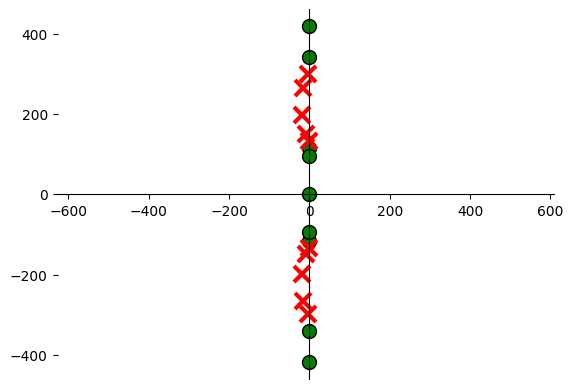

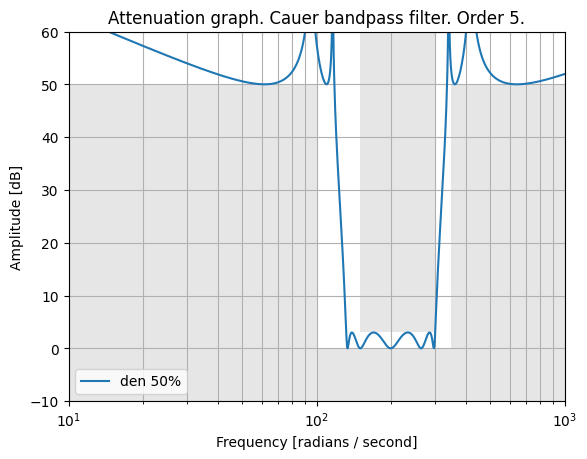

TransferFunctionContinuous(
array([2.77312393e+00, 0.00000000e+00, 8.70547475e+05, 0.00000000e+00,
       7.50092595e+10, 0.00000000e+00, 1.36852581e+15, 0.00000000e+00,
       6.85315166e+18, 0.00000000e+00]),
array([1.00000000e+00, 9.63130300e+01, 2.42722688e+05, 1.83207489e+07,
       2.14563484e+10, 1.16467417e+12, 8.50718896e+14, 2.88007471e+16,
       1.51286847e+19, 2.38015977e+20, 9.79831350e+22]),
dt: None
)


In [12]:


""" 

    Tipos de filtro:
    
    'butter'
    'cheby'
    'cheby2'
    'cauer'
"""

"""
filter = 'cheby2'
filter_type = 'lowpass'
Wpass = 150
Watt = 300
Gp = -3
Ga = -50
deg = 0.5
"""
"""
filter = 'cheby2'
filter_type = 'highpass'
Watt = 150
Wpass = 300
Gp = -3
Ga = -50
deg = 0.5
"""
"""
filter = 'cheby2'
filter_type = 'bandpass'
Watt = [100,350]
Wpass = [10,300]
Gp = -3
Ga = -50
deg = 0.5
"""

filter = 'cauer'
filter_type = 'bandpass'
Watt = [100,350]
Wpass = [150,300]
Gp = -3
Ga = -50
deg = 0.5


order, Wn = get_min_order(filter, Wpass, Watt, -Gp, -Ga)

b, a = get_filter(filter,filter_type, order, Wn,  Wpass, Watt, Gp,Ga,0.5)
return_p_z(b,a)
graph_filter('attenuation',filter,filter_type, order, Wpass, Watt, Gp,Ga,0.5,b,a)
print(signal.TransferFunction(b,a))
